# **Rapport de projet SY23 : Apprentissage par Renforcement pour le Jeu Snake**

**Samy E. et Willen A.** - *Projet SY23 - UTC - Janvier 2026*

## 1. Introduction

### 1.1 Contexte

L'apprentissage par renforcement (Reinforcement Learning, RL) est une branche du Machine Learning où un agent apprend à prendre des décisions en interagissant avec un environnement. Contrairement à l'apprentissage supervisé, l'agent ne dispose pas d'exemples étiquetés mais doit découvrir par essai-erreur quelles actions maximisent une récompense cumulative.

Le jeu Snake constitue un cas d'étude particulièrement intéressant pour le RL car il présente :
- Un espace d'états de taille variable (le serpent grandit)
- Des contraintes de collision (murs et corps du serpent)
- Un objectif clair (manger les pommes tout en survivant)
- Un compromis exploration/exploitation (chercher la pomme vs éviter les dangers)

### 1.2 Objectifs du projet

Ce projet vise à implémenter un agent capable de jouer au jeu Snake de manière autonome en utilisant l'algorithme PPO (Proximal Policy Optimization). Nous avons développé plusieurs versions de l'environnement et de l'entraînement pour étudier l'impact des différents choix de conception sur les performances de l'agent.

## 2. Installation

### 2.1 Créer un environnement virtuel
```bash
python -m venv .venv
source .venv/bin/activate  # macOS/Linux
# ou
.venv\Scripts\activate     # Windows
```
### 2.2 Installation des dépendances
```bash
!pip install gymnasium>=1.0.0 pygame>=2.6.0 stable-baselines3>=2.0.0 tensorboard>=2.0.0 numpy>=1.20.0 torch>=2.0.0 -q

 ⚠️ **macOS** : Si pygame ne s'installe pas, installez d'abord SDL2 :
> ```bash
> brew install sdl2 sdl2_image sdl2_mixer sdl2_ttf sdl2_gfx
> ```


## 3. Implémentation de l'environnement Snake

L'environnement est le coeur du projet. Il définit les règles du jeu, l'espace d'observation que l'agent perçoit, et le système de récompenses qui guide l'apprentissage.

### 3.1 Spécifications de l'environnement

| Paramètre | Valeur | Description |
|-----------|--------|-------------|
| Taille de la grille | 30x30 cases | Fenêtre de 600x600 pixels avec blocs de 20px |
| Espace d'actions | Discrete(4) | Gauche, Droite, Haut, Bas |
| Espace d'observations | Box(11,) | Vecteur de 11 valeurs binaires |
| Récompense positive | +10 | Manger une pomme |
| Récompense négative | -10 | Collision (mur ou corps) |

### 3.2 Configuration initiale et imports

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import torch
torch.set_num_threads(1)

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import pygame

print(f"Gymnasium version: {gym.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

Gymnasium version: 1.2.3
PyTorch version: 2.7.0
NumPy version: 2.1.3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


### 3.3 Constantes du jeu

Nous définissons les paramètres de base du jeu : dimensions de la fenêtre, taille des blocs, et palette de couleurs pour le rendu graphique.

In [2]:
WINDOW_WIDTH = 600
WINDOW_HEIGHT = 600
BLOCK_SIZE = 20 
SPEED = 20       


WHITE = (255, 255, 255)
BLACK = (15, 15, 25)
DARK_GRAY = (30, 30, 40)
RED = (255, 80, 80)
ORANGE = (255, 165, 0)
GREEN = (76, 175, 80)
BLUE1 = (66, 165, 245)
CYAN = (0, 188, 212)
YELLOW = (255, 235, 59)


GRID_WIDTH = WINDOW_WIDTH // BLOCK_SIZE
GRID_HEIGHT = WINDOW_HEIGHT // BLOCK_SIZE
print(f"Grille de jeu : {GRID_WIDTH}x{GRID_HEIGHT} cases")
print(f"Nombre total de positions possibles : {GRID_WIDTH * GRID_HEIGHT}")

Grille de jeu : 30x30 cases
Nombre total de positions possibles : 900


### 3.4 Classe SnakeEnv : Structure principale

L'environnement hérite de `gym.Env` et doit implémenter les méthodes standard :
- `__init__()` : Initialisation des espaces d'action et d'observation
- `reset()` : Réinitialisation de l'environnement
- `step(action)` : Exécution d'une action et retour de l'observation, récompense, etc.

In [3]:
class SnakeEnv(gym.Env):
    
    metadata = {'render_modes': ['human'], 'render_fps': SPEED}

    def __init__(self, render_mode=None):
        super(SnakeEnv, self).__init__()
        
        
        self.w = WINDOW_WIDTH
        self.h = WINDOW_HEIGHT
        self.render_mode = render_mode
        
        
        self.window = None
        self.clock = None
        self.font = None
        self.small_font = None
        
        # ESPACE D'ACTIONS : 4 directions possibles
        # 0: Gauche, 1: Droite, 2: Haut, 3: Bas
        self.action_space = spaces.Discrete(4)
        
        # ESPACE D'OBSERVATIONS : Vecteur de 11 valeurs binaires
        # [danger_devant, danger_droite, danger_gauche,
        #  dir_gauche, dir_droite, dir_haut, dir_bas,
        #  pomme_gauche, pomme_droite, pomme_haut, pomme_bas]
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(11,), dtype=np.int8
        )
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        
        self.direction = 1  
        self.head = [self.w / 2, self.h / 2]
        self.snake = [
            self.head,
            [self.head[0] - BLOCK_SIZE, self.head[1]],
            [self.head[0] - 2 * BLOCK_SIZE, self.head[1]]
        ]
        
        self.score = 0
        self.frame_iteration = 0
        self._place_food()
        
        return self._get_observation(), {}
    
    def step(self, action):
        """Exécute une action et retourne le nouvel état."""
        self.frame_iteration += 1
        
       
        self._move(action)
        
        
        game_over = False
        reward = 0
        
        # Condition de fin : collision ou trop de frames sans manger
        if self._is_collision() or self.frame_iteration > 100 * len(self.snake):
            game_over = True
            reward = -10
            return self._get_observation(), reward, game_over, False, {}
        
        # 3. Vérifier si le serpent mange la pomme
        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()
        else:
            self.snake.pop()
        
        if self.render_mode == "human":
            self._render_frame()
        
        return self._get_observation(), reward, game_over, False, {}
    
    def _get_observation(self):
        """
        Construit le vecteur d'observation de 11 valeurs.
        
        C'est la représentation de l'état que l'agent perçoit.
        On encode les informations de manière relative à la direction actuelle.
        """
        head = self.snake[0]
        
        point_l = [head[0] - BLOCK_SIZE, head[1]]
        point_r = [head[0] + BLOCK_SIZE, head[1]]
        point_u = [head[0], head[1] - BLOCK_SIZE]
        point_d = [head[0], head[1] + BLOCK_SIZE]
        
        dir_l = self.direction == 0
        dir_r = self.direction == 1
        dir_u = self.direction == 2
        dir_d = self.direction == 3
        
        state = [
            # Danger en face  
            (dir_r and self._is_collision(point_r)) or
            (dir_l and self._is_collision(point_l)) or
            (dir_u and self._is_collision(point_u)) or
            (dir_d and self._is_collision(point_d)),
            
            # à droite 
            (dir_u and self._is_collision(point_r)) or
            (dir_d and self._is_collision(point_l)) or
            (dir_l and self._is_collision(point_u)) or
            (dir_r and self._is_collision(point_d)),
            
            # à gauche 
            (dir_d and self._is_collision(point_r)) or
            (dir_u and self._is_collision(point_l)) or
            (dir_r and self._is_collision(point_u)) or
            (dir_l and self._is_collision(point_d)),
            
            
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            # position de la pomme
            self.food[0] < self.head[0],  
            self.food[0] > self.head[0],  
            self.food[1] < self.head[1],  
            self.food[1] > self.head[1]   
        ]
        
        return np.array(state, dtype=np.int8)
    
    # on place la pomme de manière aléatoire
    def _place_food(self):
        x = random.randint(0, (self.w - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE
        y = random.randint(0, (self.h - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE
        self.food = [x, y]
        
        if self.food in self.snake:
            self._place_food()
    
    def _is_collision(self, pt=None):
        """Vérifie si un point est en collision avec un mur ou le corps."""
        if pt is None:
            pt = self.head
        
       
        if pt[0] > self.w - BLOCK_SIZE or pt[0] < 0:
            return True
        if pt[1] > self.h - BLOCK_SIZE or pt[1] < 0:
            return True
        
        
        if pt in self.snake[1:]:
            return True
        
        return False
    
    def _move(self, action):
        if action == 0 and self.direction != 1:
            self.direction = 0  # Gauche
        elif action == 1 and self.direction != 0:
            self.direction = 1  # Droite
        elif action == 2 and self.direction != 3:
            self.direction = 2  # Haut
        elif action == 3 and self.direction != 2:
            self.direction = 3  # Bas
        
        x, y = self.head
        if self.direction == 0:
            x -= BLOCK_SIZE
        elif self.direction == 1:
            x += BLOCK_SIZE
        elif self.direction == 2:
            y -= BLOCK_SIZE
        elif self.direction == 3:
            y += BLOCK_SIZE
        
        self.head = [x, y]
        self.snake.insert(0, self.head)
    
    #Affichage 
    def _render_frame(self):
        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode((self.w, self.h))
            self.clock = pygame.time.Clock()
            self.font = pygame.font.Font(None, 48)
            self.small_font = pygame.font.Font(None, 32)
            pygame.display.set_caption("Snake AI")
        
        pygame.event.pump()
        self.window.fill(BLACK)
        
        # Grille 
        for x in range(0, self.w, BLOCK_SIZE):
            pygame.draw.line(self.window, DARK_GRAY, (x, 0), (x, self.h), 1)
        for y in range(0, self.h, BLOCK_SIZE):
            pygame.draw.line(self.window, DARK_GRAY, (0, y), (self.w, y), 1)
        
        # Pomme
        pygame.draw.rect(
            self.window, RED,
            pygame.Rect(self.food[0], self.food[1], BLOCK_SIZE, BLOCK_SIZE)
        )
        
        # Serpent
        for i, pt in enumerate(self.snake):
            color = CYAN if i == 0 else BLUE1
            pygame.draw.rect(
                self.window, color,
                pygame.Rect(pt[0], pt[1], BLOCK_SIZE - 1, BLOCK_SIZE - 1)
            )
        
        # Score
        text = self.font.render(f"Score: {self.score}", True, GREEN)
        self.window.blit(text, (10, 10))
        
        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])
    
    def close(self):
        """Ferme proprement l'environnement."""
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

### 3.5 Explication du vecteur d'observation

Le choix d'un vecteur de 11 valeurs binaires est crucial. Cette représentation compacte encode toutes les informations nécessaires à la prise de décision :

| Index | Description | Utilité |
|-------|-------------|--------|
| 0 | Danger tout droit | Éviter la collision frontale |
| 1 | Danger à droite | Éviter la collision latérale |
| 2 | Danger à gauche | Éviter la collision latérale |
| 3-6 | Direction actuelle (one-hot) | Contexte de mouvement |
| 7-10 | Position relative de la pomme | Objectif à atteindre |

Cette représentation est relative à la direction du serpent, ce qui simplifie l'apprentissage car l'agent n'a pas besoin d'apprendre les symétries du jeu.

### 3.6 Test de l'environnement

Vérifions que l'environnement fonctionne correctement avec quelques actions aléatoires.

In [4]:
env = SnakeEnv()

print("Espace d'actions:", env.action_space)
print("Espace d'observations:", env.observation_space)
print()

obs, info = env.reset(seed=42)
print("Observation initiale:")
print(f"  Forme: {obs.shape}")
print(f"  Valeurs: {obs}")
print(f"  Position tête: {env.head}")
print(f"  Position pomme: {env.food}")
print()

print("Test de 5 actions aléatoires:")
for i in range(5):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    action_names = ['Gauche', 'Droite', 'Haut', 'Bas']
    print(f"  Action {i+1}: {action_names[action]}, Reward: {reward}, Done: {done}")
    if done:
        break

env.close()

Espace d'actions: Discrete(4)
Espace d'observations: Box(0, 1, (11,), int8)

Observation initiale:
  Forme: (11,)
  Valeurs: [0 0 0 0 1 0 0 0 1 0 1]
  Position tête: [300.0, 300.0]
  Position pomme: [540, 560]

Test de 5 actions aléatoires:
  Action 1: Bas, Reward: 0, Done: False
  Action 2: Bas, Reward: 0, Done: False
  Action 3: Haut, Reward: 0, Done: False
  Action 4: Haut, Reward: 0, Done: False
  Action 5: Droite, Reward: 0, Done: False


### 3.7 Validation avec Stable-Baselines3

Stable-Baselines3 fournit un outil pour vérifier la compatibilité de l'environnement.

In [5]:
from stable_baselines3.common.env_checker import check_env

env = SnakeEnv()
try:
    check_env(env, warn=True)
    print("L'environnement est compatible avec Stable-Baselines3.")
except Exception as e:
    print(f"Erreur de compatibilité: {e}")
finally:
    env.close()

L'environnement est compatible avec Stable-Baselines3.


---

## 4. Version 1 : Premier entraînement

Cette première version constitue notre baseline. L'objectif est d'obtenir un agent fonctionnel avec une configuration minimale pour établir une référence de performance.

### 4.1 Configuration de la V1

| Paramètre | Valeur | Justification |
|-----------|--------|---------------|
| Algorithme | PPO | Stable et efficace pour les espaces discrets |
| Politique | MlpPolicy | Réseau fully-connected adapté aux observations vectorielles |
| Architecture | [64, 64] | Configuration par défaut de SB3 |
| Timesteps | 100 000 | Premier test rapide |
| Learning rate | 0.0003 | Valeur par défaut |

### 4.2 Code d'entraînement V1

In [6]:
from stable_baselines3 import PPO


MODELS_DIR_V1 = "checkpoints/PPO_v1"
LOG_DIR = "logs"

os.makedirs(MODELS_DIR_V1, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

env_v1 = SnakeEnv()

model_v1 = PPO(
    policy="MlpPolicy",
    env=env_v1,
    verbose=1,
    tensorboard_log=LOG_DIR
)

print("Modèle V1 initialisé")
print(f"Architecture du réseau : {model_v1.policy}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Modèle V1 initialisé
Architecture du réseau : ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=11, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=11, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=4, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=

### 4.3 Lancement de l'entraînement V1

L'entraînement de 100 000 timesteps prend environ 2-3 minutes sur un processeur moderne.

In [7]:
TIMESTEPS_V1 = 100_000

print(f"Démarrage de l'entraînement V1 ({TIMESTEPS_V1:,} timesteps)...")
print("-" * 50)

model_v1.learn(total_timesteps=TIMESTEPS_V1)


model_v1.save(f"{MODELS_DIR_V1}/snake_v1_final")
print("-" * 50)
print(f"Entraînement V1 terminé !")
print(f"Modèle sauvegardé : {MODELS_DIR_V1}/snake_v1_final.zip")

Démarrage de l'entraînement V1 (100,000 timesteps)...
--------------------------------------------------
Logging to logs/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | -8.24    |
| time/              |          |
|    fps             | 5692     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 106         |
|    ep_rew_mean          | -8.92       |
| time/                   |             |
|    fps                  | 3506        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008909339 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0

### 4.4 Évaluation de la V1

Testons les performances du modèle entraîné sur plusieurs épisodes.

In [8]:
def evaluate_model(model, env, n_episodes=10):
   
    scores = []
    lengths = []
    
    for episode in range(n_episodes):
        obs, _ = env.reset()
        done = False
        episode_length = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            episode_length += 1
        
        scores.append(env.score)
        lengths.append(episode_length)
    
    return scores, lengths

env_eval = SnakeEnv()
scores_v1, lengths_v1 = evaluate_model(model_v1, env_eval, n_episodes=20)
env_eval.close()

print("Résultats V1 sur 20 épisodes:")
print(f"  Score moyen     : {np.mean(scores_v1):.2f} (+/- {np.std(scores_v1):.2f})")
print(f"  Score max       : {max(scores_v1)}")
print(f"  Score min       : {min(scores_v1)}")
print(f"  Durée moyenne   : {np.mean(lengths_v1):.0f} steps")

Résultats V1 sur 20 épisodes:
  Score moyen     : 19.75 (+/- 10.65)
  Score max       : 42
  Score min       : 1
  Durée moyenne   : 436 steps


### 4.5 Visualisation du jeu V1

Lancez cette cellule pour voir l'agent V1 jouer en temps réel. Fermez la fenêtre Pygame pour arrêter.

In [9]:
import time

def play_game(model, n_games=3, delay=0.05):

    env_play = SnakeEnv(render_mode="human")
    
    for game in range(n_games):
        obs, _ = env_play.reset()
        done = False
        print(f"\nPartie {game + 1}/{n_games}")
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env_play.step(action)
            time.sleep(delay)
        
        print(f"  Score final : {env_play.score}")
    
    env_play.close()
    print("\nVisualisations terminées.")

print("Lancement du jeu avec le modèle V1...")
play_game(model_v1, n_games=3, delay=0.05)

Lancement du jeu avec le modèle V1...

Partie 1/3
  Score final : 25

Partie 2/3
  Score final : 24

Partie 3/3
  Score final : 32

Visualisations terminées.


### 4.5 Analyse de la V1

Pour une première version, nous avons obtenu des scores plutôt bons et supérieurs à nos attentes. Cependant, plusieurs points d’amélioration peuvent être soulignés :

- **Nombre de timesteps insuffisant** : 100k steps ne permettent pas une convergence optimale
-  **Architecture réseau limitée** : Le réseau [64, 64] par défaut peut manquer de capacité
- **Pas de checkpoints** : Impossible de reprendre l'entraînement ou d'analyser la progression
- **Interface**: l’environnement de visualisation reste minimaliste


---

## 5. Version 2 : Entraînement avancé

La version 2 améliore significativement l'entraînement avec :
- Un réseau de neurones plus large
- Plus de timesteps d'entraînement
- Un système de checkpoints pour sauvegarder la progression

### 5.1 Configuration de la V2

| Paramètre | V2 | Justification |  
|-----------|----|-------------------|
| Architecture  | [128, 128] | Plus de capacité d'apprentissage |
| Timesteps | 2 000 000 | Convergence plus complète |
| Learning rate | 0.0003 | Valeur standard efficace |
| Gamma  | 0.99 | Vision long terme |
| Checkpoints | Tous les 100k | Suivi de progression |

### 5.2 Code d'entraînement V2

In [10]:
from stable_baselines3.common.callbacks import CheckpointCallback

MODELS_DIR_V2 = "checkpoints/PPO_v2"
TIMESTEPS_V2 = 2_000_000  
SAVE_FREQ = 100_000       

os.makedirs(MODELS_DIR_V2, exist_ok=True)

env_v2 = SnakeEnv()

checkpoint_callback = CheckpointCallback(
    save_freq=SAVE_FREQ,
    save_path=MODELS_DIR_V2,
    name_prefix="snake_v2"
)

policy_kwargs = dict(
    net_arch=[128, 128] 
)

model_v2 = PPO(
    policy="MlpPolicy",
    env=env_v2,
    verbose=1,
    tensorboard_log=LOG_DIR,
    learning_rate=0.0003,
    gamma=0.99,
    policy_kwargs=policy_kwargs
)

print("Modèle V2 initialisé")
print(f"Architecture : {policy_kwargs['net_arch']}")
print(f"Timesteps prévus : {TIMESTEPS_V2:,}")
print(f"Checkpoints tous les {SAVE_FREQ:,} steps")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Modèle V2 initialisé
Architecture : [128, 128]
Timesteps prévus : 2,000,000
Checkpoints tous les 100,000 steps


### 5.3 Lancement de l'entraînement V2

L'entraînement de 2 millions de timesteps prend environ 10-30 minutes.

In [11]:
print(f"Démarrage de l'entraînement V2 ({TIMESTEPS_V2:,} timesteps)...")
print(f"Checkpoints sauvegardés dans : {MODELS_DIR_V2}")
print("-" * 50)

model_v2.learn(
    total_timesteps=TIMESTEPS_V2,
    callback=checkpoint_callback
)

print("-" * 50)
print("Entraînement V2 terminé !")

Démarrage de l'entraînement V2 (2,000,000 timesteps)...
Checkpoints sauvegardés dans : checkpoints/PPO_v2
--------------------------------------------------
Logging to logs/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 83.5     |
|    ep_rew_mean     | -8.33    |
| time/              |          |
|    fps             | 4363     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.8        |
|    ep_rew_mean          | -8.5        |
| time/                   |             |
|    fps                  | 3380        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012925271 |
|    clip_fraction 

### 5.4 Évaluation de la V2

In [12]:
env_eval_v2 = SnakeEnv()
scores_v2, lengths_v2 = evaluate_model(model_v2, env_eval_v2, n_episodes=20)
env_eval_v2.close()

print("Résultats V2 sur 20 épisodes:")
print(f"  Score moyen     : {np.mean(scores_v2):.2f} (+/- {np.std(scores_v2):.2f})")
print(f"  Score max       : {max(scores_v2)}")
print(f"  Score min       : {min(scores_v2)}")
print(f"  Durée moyenne   : {np.mean(lengths_v2):.0f} steps")

Résultats V2 sur 20 épisodes:
  Score moyen     : 27.15 (+/- 12.78)
  Score max       : 44
  Score min       : 5
  Durée moyenne   : 596 steps


### 5.5 Visualisation du jeu V2

Lancez cette cellule pour voir l'agent V2 jouer en temps réel. Fermez la fenêtre Pygame pour arrêter.

In [15]:
print("Lancement du jeu avec le modèle V2...")
play_game(model_v2, n_games=3, delay=0.05)

Lancement du jeu avec le modèle V2...

Partie 1/3
  Score final : 24

Partie 2/3
  Score final : 27

Partie 3/3
  Score final : 40

Visualisations terminées.


---

## 6. Version 3 : Vision par Convolution (CNN)

### 6.1 Analyse des limitations de la V2

Les versions V1 et V2 souffrent d'un problème fondamental : **la myopie**. L'agent ne perçoit que :
- Les dangers immédiats (cases adjacentes à la tête)
- La direction générale de la pomme

**Ce que l'agent ne voit pas :**
- La forme complète de son propre corps
- Les "culs-de-sac" qu'il crée en se déplaçant
- Les impasses formées par sa queue

**Conséquence :** Dès que le serpent devient long, il finit par s'enfermer lui-même car il ne peut pas anticiper qu'il entre dans une zone fermée.

### 6.2 La solution : Représentation spatiale

Pour résoudre ce problème, nous passons d'une représentation vectorielle (11 valeurs) à une **représentation matricielle** de la grille complète. L'agent "voit" le plateau comme une image.

| Aspect | V1/V2 (Vecteur) | V3 (Image) |
|--------|-----------------|------------|
| Observation | Box(11,) | Box(30, 30, 3) |
| Information | Locale (dangers proches) | Globale (grille entière) |
| Réseau | MLP [64, 64] ou [128, 128] | CNN (Convolutions) |
| Capacité | Réactive | Anticipative |

### 6.3 Codage de l'observation

La grille est encodée comme une "image" RGB où chaque canal représente un élément :

| Canal | Élément | Valeur |
|-------|---------|--------|
| 0 (Rouge) | Corps du serpent | 255 si présent, 0 sinon |
| 1 (Vert) | Tête du serpent | 255 si présent, 0 sinon |
| 2 (Bleu) | Pomme | 255 si présent, 0 sinon |

Cette représentation permet au CNN de détecter les patterns spatiaux (formes en U, impasses, etc.).

### 6.4 Implémentation de l'environnement CNN

L'environnement `SnakeEnvCNN` modifie principalement la méthode `_get_observation()` pour retourner une matrice 3D représentant la grille complète.

In [17]:
class SnakeEnvCNN(gym.Env):
    """
    Reward  mis en place:
    - +10   : Manger une pomme
    - -10   : Collision (game over)
    - +0.1  : Se rapprocher de la pomme
    - -0.3  : S'éloigner de la pomme (asymétrique pour éviter l'oscillation)
    - -0.01 : Coût par step (encourage l'efficacité)
    """
    metadata = {'render_modes': ['human'], 'render_fps': SPEED}

    def __init__(self, render_mode=None):
        super(SnakeEnvCNN, self).__init__()
        
        
        self.grid_w = GRID_WIDTH   
        self.grid_h = GRID_HEIGHT 
        self.w = WINDOW_WIDTH
        self.h = WINDOW_HEIGHT
        self.render_mode = render_mode
        
       
        self.window = None
        self.clock = None
        self.font = None
        
       
        self.action_space = spaces.Discrete(4)
        
       
        self.observation_space = spaces.Box(
            low=0, 
            high=255, 
            shape=(self.grid_h, self.grid_w, 3), 
            dtype=np.uint8
        )
    
    def _get_distance_to_food(self):
        return abs(self.head[0] - self.food[0]) + abs(self.head[1] - self.food[1])
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        
        center_x = self.grid_w // 2
        center_y = self.grid_h // 2
        
        self.direction = 1  
        self.head = [center_x, center_y]
        self.snake = [
            self.head.copy(),
            [center_x - 1, center_y],
            [center_x - 2, center_y]
        ]
        
        self.score = 0
        self.frame_iteration = 0
        self._place_food()
        
        
        self.prev_distance = self._get_distance_to_food()
        
        return self._get_observation(), {}
    
    def step(self, action):
        self.frame_iteration += 1
        
        
        self._move(action)
        
        
        game_over = False
        reward = -0.01  
        
        
        if self._is_collision() or self.frame_iteration > 100 * len(self.snake):
            game_over = True
            reward = -10
            return self._get_observation(), reward, game_over, False, {}
        
        
        current_distance = self._get_distance_to_food()
        
        
        if self.head == self.food:
            self.score += 1
            reward = 10
            self._place_food()
            self.prev_distance = self._get_distance_to_food()
        else:
            
            if current_distance < self.prev_distance:
                reward += 0.1   
            elif current_distance > self.prev_distance:
                reward += -0.3 
            
            
            self.prev_distance = current_distance
            self.snake.pop()
        
        if self.render_mode == "human":
            self._render_frame()
        
        return self._get_observation(), reward, game_over, False, {}
    
    def _get_observation(self):
       
        obs = np.zeros((self.grid_h, self.grid_w, 3), dtype=np.uint8)
        
        # canal 0 (corps)
        for segment in self.snake[1:]:
            x, y = int(segment[0]), int(segment[1])
            if 0 <= x < self.grid_w and 0 <= y < self.grid_h:
                obs[y, x, 0] = 255
        
        # canal 1 (tête)
        hx, hy = int(self.head[0]), int(self.head[1])
        if 0 <= hx < self.grid_w and 0 <= hy < self.grid_h:
            obs[hy, hx, 1] = 255
        
        # canal 2 (pomme)
        fx, fy = int(self.food[0]), int(self.food[1])
        if 0 <= fx < self.grid_w and 0 <= fy < self.grid_h:
            obs[fy, fx, 2] = 255
        
        return obs
    
    def _place_food(self):
        x = random.randint(0, self.grid_w - 1)
        y = random.randint(0, self.grid_h - 1)
        self.food = [x, y]
        
        if self.food in self.snake:
            self._place_food()
    
    def _is_collision(self, pt=None):
        if pt is None:
            pt = self.head
        
        if pt[0] >= self.grid_w or pt[0] < 0:
            return True
        if pt[1] >= self.grid_h or pt[1] < 0:
            return True
        
        if pt in self.snake[1:]:
            return True
        
        return False
    
    def _move(self, action):
        if action == 0 and self.direction != 1:
            self.direction = 0
        elif action == 1 and self.direction != 0:
            self.direction = 1
        elif action == 2 and self.direction != 3:
            self.direction = 2
        elif action == 3 and self.direction != 2:
            self.direction = 3
        
        x, y = self.head
        if self.direction == 0:
            x -= 1
        elif self.direction == 1:
            x += 1
        elif self.direction == 2:
            y -= 1
        elif self.direction == 3:
            y += 1
        
        self.head = [x, y]
        self.snake.insert(0, self.head.copy())
    
    def _render_frame(self):
        if self.window is None:
            pygame.init()
            self.window = pygame.display.set_mode((self.w, self.h))
            self.clock = pygame.time.Clock()
            self.font = pygame.font.Font(None, 48)
            pygame.display.set_caption("Snake AI - CNN")
        
        pygame.event.pump()
        self.window.fill(BLACK)
        
        
        for x in range(0, self.w, BLOCK_SIZE):
            pygame.draw.line(self.window, DARK_GRAY, (x, 0), (x, self.h), 1)
        for y in range(0, self.h, BLOCK_SIZE):
            pygame.draw.line(self.window, DARK_GRAY, (0, y), (self.w, y), 1)
        
        
        pygame.draw.rect(
            self.window, RED,
            pygame.Rect(self.food[0] * BLOCK_SIZE, self.food[1] * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE)
        )
        
       
        for i, pt in enumerate(self.snake):
            color = CYAN if i == 0 else BLUE1
            pygame.draw.rect(
                self.window, color,
                pygame.Rect(pt[0] * BLOCK_SIZE, pt[1] * BLOCK_SIZE, BLOCK_SIZE - 1, BLOCK_SIZE - 1)
            )
        
        text = self.font.render(f"Score: {self.score}", True, GREEN)
        self.window.blit(text, (10, 10))
        
        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])
    
    def close(self):
       
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


### 6.5 Visualisation de l'observation CNN

Vérifions visuellement ce que l'agent perçoit avec cette nouvelle représentation.

Shape de l'observation : (30, 30, 3)
Type : uint8
Valeurs min/max : 0, 255


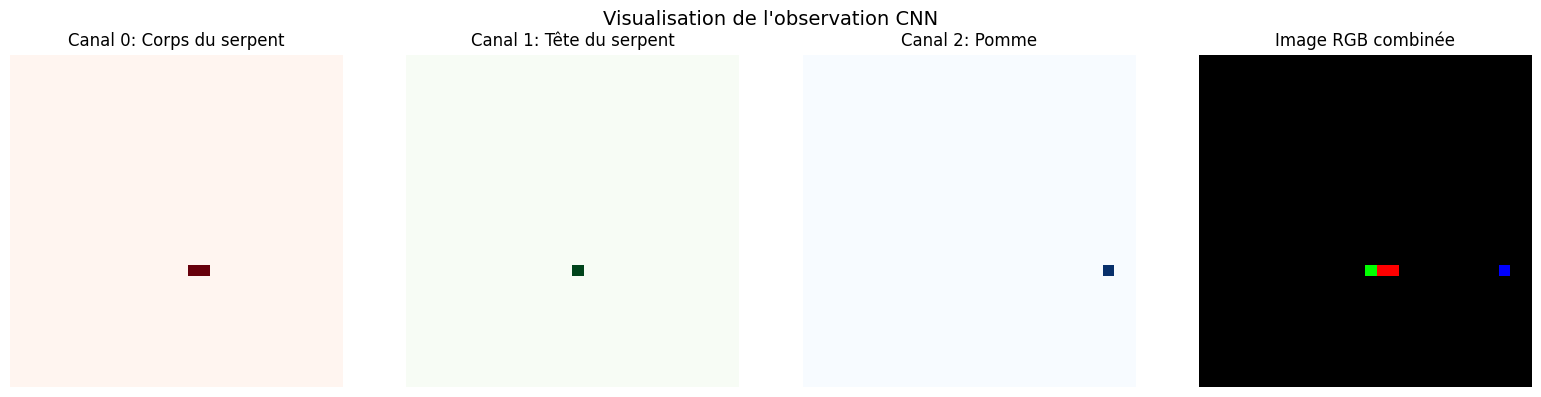

In [18]:
import matplotlib.pyplot as plt

env_cnn_test = SnakeEnvCNN()
obs, _ = env_cnn_test.reset(seed=42)

for _ in range(10):
    action = env_cnn_test.action_space.sample()
    obs, _, done, _, _ = env_cnn_test.step(action)
    if done:
        obs, _ = env_cnn_test.reset()

print(f"Shape de l'observation : {obs.shape}")
print(f"Type : {obs.dtype}")
print(f"Valeurs min/max : {obs.min()}, {obs.max()}")

fig, axes = plt.subplots(1, 4, figsize=(16, 4))


axes[0].imshow(obs[:, :, 0], cmap='Reds')
axes[0].set_title('Canal 0: Corps du serpent')
axes[0].axis('off')

axes[1].imshow(obs[:, :, 1], cmap='Greens')
axes[1].set_title('Canal 1: Tête du serpent')
axes[1].axis('off')

axes[2].imshow(obs[:, :, 2], cmap='Blues')
axes[2].set_title('Canal 2: Pomme')
axes[2].axis('off')

axes[3].imshow(obs)
axes[3].set_title('Image RGB combinée')
axes[3].axis('off')

plt.suptitle("Visualisation de l'observation CNN", fontsize=14)
plt.tight_layout()
plt.show()

env_cnn_test.close()

### 6.6 Validation de l'environnement CNN

In [19]:
env_cnn_check = SnakeEnvCNN()
try:
    check_env(env_cnn_check, warn=True)
    print("L'environnement CNN est compatible avec Stable-Baselines3.")
except Exception as e:
    print(f"Erreur de compatibilité: {e}")
finally:
    env_cnn_check.close()

L'environnement CNN est compatible avec Stable-Baselines3.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:88: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  warnings.warn(


### 6.7 Configuration de l'entraînement V3

La version CNN nécessite des ajustements par rapport aux versions MLP :

| Paramètre | V2 (MLP) | V3 (CNN) | Justification |
|-----------|----------|----------|---------------|
| Policy | MlpPolicy | CnnPolicy | Adapté aux entrées images |
| Architecture | [128, 128] | NatureCNN modifié | Convolutions pour patterns spatiaux |
| Timesteps | 2M | 3M+ | CNN plus lent à converger |
| Learning rate | 0.0003 | 0.0001 | Plus stable pour CNN |
| n_steps | 2048 | 2048 | Collecte plus d'expérience |

**Note sur l'architecture CNN** : Stable-Baselines3 utilise par défaut l'architecture "NatureCNN" (inspirée des travaux de DeepMind sur Atari). Nous allons définir une architecture personnalisée adaptée à notre grille 30x30.

In [20]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn

class CustomCNN(BaseFeaturesExtractor):
    
    def __init__(self, observation_space, features_dim=256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        
        
        n_input_channels = observation_space.shape[0]
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            
        
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), 
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(64 * 7 * 7, features_dim),
            nn.ReLU(),
        )
    
    def forward(self, observations):
        x = observations.float() / 255.0
        return self.linear(self.cnn(x))

print("Architecture CustomCNN définie.")


Architecture CustomCNN définie.


### 6.8 Initialisation du modèle V3

In [26]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.utils import set_random_seed

def make_env(rank, seed=0):
    """Crée une fonction qui retourne un environnement."""
    def _init():
        env = SnakeEnvCNN()
        env.reset(seed=seed + rank)
        return env
    set_random_seed(seed)
    return _init

# Configuration V3 OPTIMISÉE
MODELS_DIR_V3 = "checkpoints/PPO_CNN"
TIMESTEPS_V3 = 3_000_000
SAVE_FREQ_V3 = 200_000
N_ENVS = 2  # Nombre d'environnements parallèles (ajuster selon CPU)

os.makedirs(MODELS_DIR_V3, exist_ok=True)

# Vérifier si GPU disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device utilisé : {device}")

# Création des environnements vectorisés (BEAUCOUP plus rapide)
print(f"Création de {N_ENVS} environnements parallèles...")
env_v3 = SubprocVecEnv([make_env(i) for i in range(N_ENVS)])
env_v3 = VecMonitor(env_v3)  # Pour le logging

# Callback pour checkpoints (ajuster save_freq pour les envs parallèles)
checkpoint_callback_v3 = CheckpointCallback(
    save_freq=max(SAVE_FREQ_V3 // N_ENVS, 1),  # Diviser par N_ENVS
    save_path=MODELS_DIR_V3,
    name_prefix="snake_v3_cnn"
)

# Configuration du modèle OPTIMISÉE
policy_kwargs_v3 = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=256),
    net_arch=[128, 64],
)

# Modèle avec optimisations
model_v3 = PPO(
    policy="CnnPolicy",
    env=env_v3,
    verbose=1,
    tensorboard_log=LOG_DIR,
    learning_rate=5e-4,        # Learning rate plus élevé (converge plus vite)
    gamma=0.99,
    n_steps=2048,               # Moins de steps (plus de mises à jour)
    batch_size=256,            # Batch plus grand (meilleure utilisation GPU)
    n_epochs=10,                # Moins d'epochs (plus rapide)
    clip_range=0.2,
    ent_coef=0.005,             # Encourage l'exploration
    policy_kwargs=policy_kwargs_v3,
    device=device              # Utilise GPU si disponible
)


Device utilisé : cpu
Création de 2 environnements parallèles...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Using cpu device
Wrapping the env in a VecTransposeImage.


### 6.9 Lancement de l'entraînement V3

⚠️ **Attention** : L'entraînement de 3 millions de timesteps avec CNN est significativement plus long que les versions MLP (environ 1-2 heures selon votre machine).

In [ ]:
model_v3.learn(
    total_timesteps=TIMESTEPS_V3,
    callback=checkpoint_callback_v3
)
model_v3.save(f"{MODELS_DIR_V3}/snake_v3_cnn_final")

env_v3.close()

print("-" * 60)
print("Entraînement V3 terminé !")
print(f"Modèle sauvegardé : {MODELS_DIR_V3}/snake_v3_cnn_final.zip")

### 6.10 Évaluation de la V3

In [27]:
# Évaluation sur 20 épisodes
env_eval_v3 = SnakeEnvCNN()
scores_v3, lengths_v3 = evaluate_model(model_v3, env_eval_v3, n_episodes=20)
env_eval_v3.close()

print("=" * 60)
print("Résultats V3 (CNN) sur 20 épisodes:")
print("=" * 60)
print(f"  Score moyen     : {np.mean(scores_v3):.2f} (+/- {np.std(scores_v3):.2f})")
print(f"  Score max       : {max(scores_v3)}")
print(f"  Score min       : {min(scores_v3)}")
print(f"  Durée moyenne   : {np.mean(lengths_v3):.0f} steps")
print("=" * 60)

Résultats V3 (CNN) sur 20 épisodes:
  Score moyen     : 0.15 (+/- 0.36)
  Score max       : 1
  Score min       : 0
  Durée moyenne   : 36 steps


### 6.11 Visualisation du jeu V3

Lancez cette cellule pour voir l'agent CNN jouer. Vous devriez observer un comportement plus "anticipatif" : l'agent évite de s'enfermer lui-même.

In [30]:
def play_game_cnn(model, n_games=3, delay=0.05):
    """
    Lance le jeu avec l'environnement CNN pour visualiser l'agent V3.
    """
    env_play = SnakeEnvCNN(render_mode="human")
    
    for game in range(n_games):
        obs, _ = env_play.reset()
        done = False
        print(f"\nPartie {game + 1}/{n_games}")
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env_play.step(action)
            time.sleep(delay)
        
        print(f"  Score final : {env_play.score}")
    
    env_play.close()
    print("\nVisualisations terminées.")

# Lancer 3 parties avec le modèle V3
print("Lancement du jeu avec le modèle V3 (CNN)...")
play_game_cnn(model_v3, n_games=3, delay=0.05)

Lancement du jeu avec le modèle V3 (CNN)...

Partie 1/3
  Score final : 0

Partie 2/3
  Score final : 0

Partie 3/3
  Score final : 0

Visualisations terminées.


### 6.11 Tensorboard

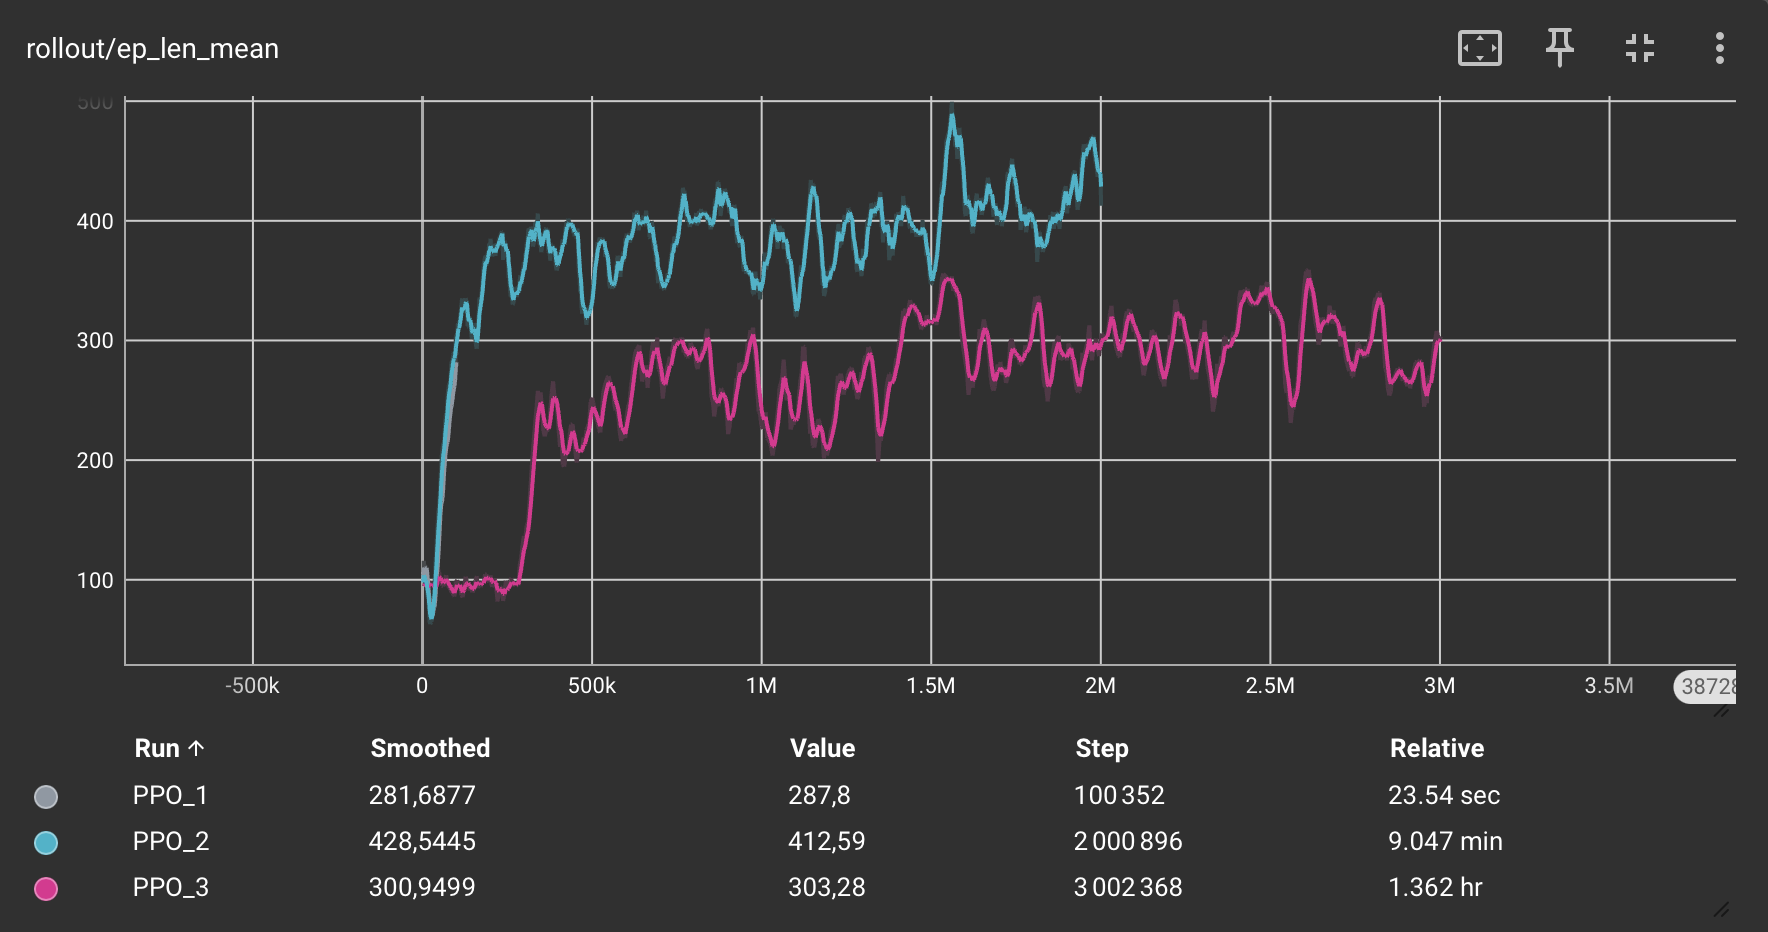

In [37]:
from PIL import Image
from IPython.display import display

img_path = "projet_snake/img/graphique.png"

img = Image.open(img_path)
display(img)  


Graphique du nombre de pas moyen du snake. Cette métrique nous permet de voir que le snake survit et ne se suicide pas directement, mais la question du nombre de pommes mangées demeure

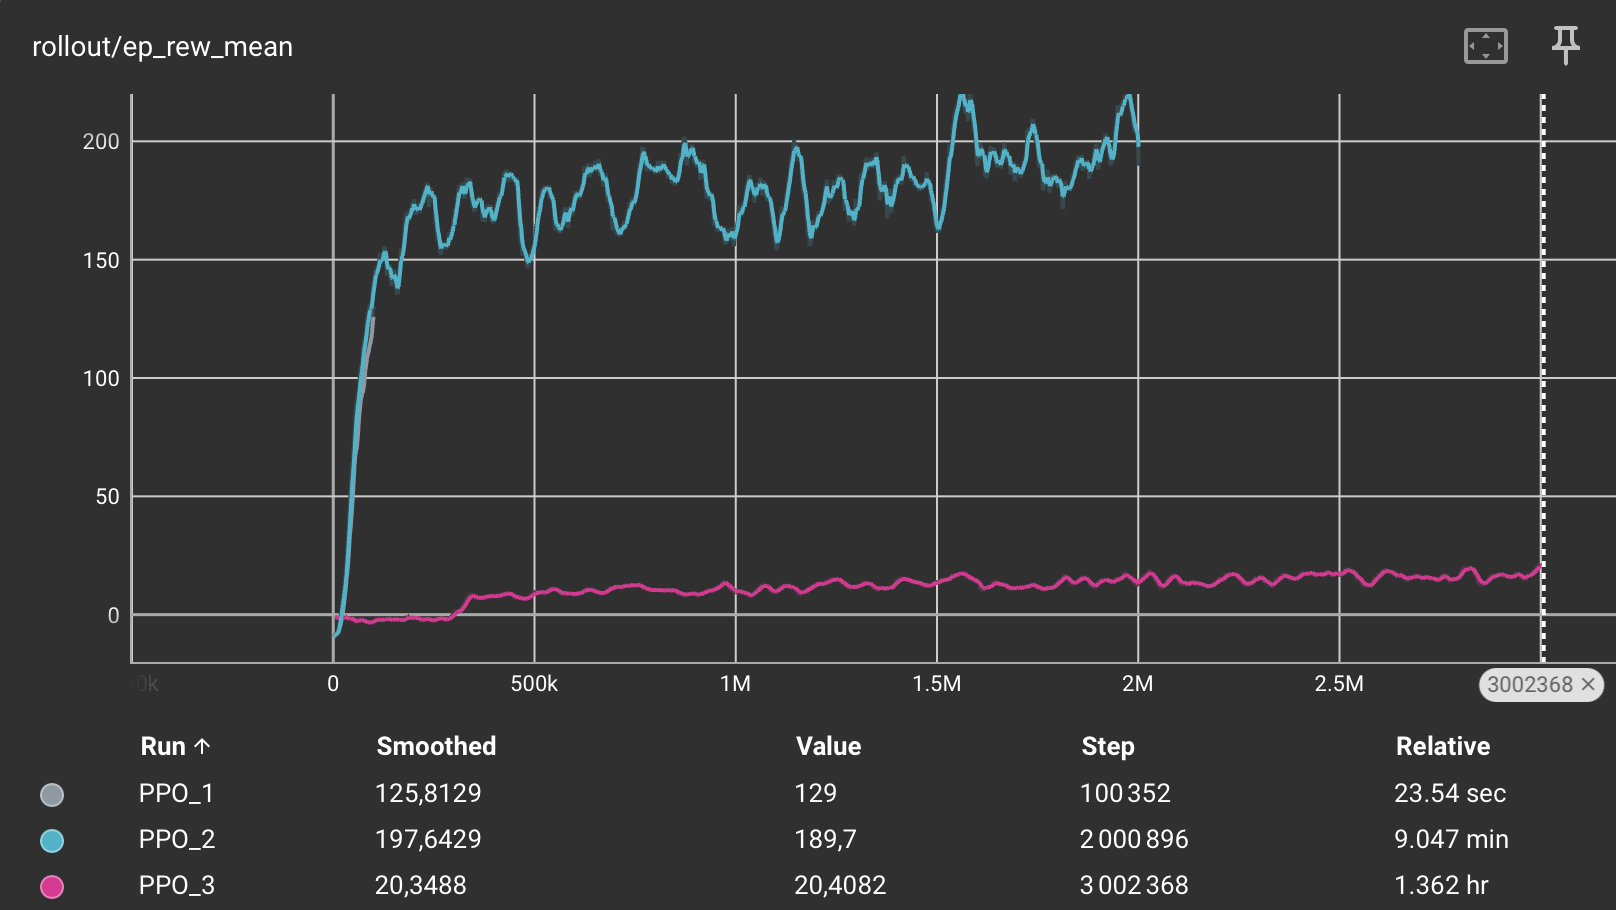

In [38]:
from PIL import Image
from IPython.display import display

img_path = "projet_snake/img/graphique2.png"

img = Image.open(img_path)
display(img)  


Graphique du reward moyen du snake. On peut voir que le reward du CNN n'évolue pas, il reste constant et n'apprend pas.

---

## 7. Analyse comparative V1 vs V2 vs V3

### 7.1 Comparaison des performances

Cette section compare les trois versions entraînées sur les mêmes métriques.

In [31]:
N_EVAL_EPISODES = 50

print("Évaluation comparative sur 50 épisodes par version...")
print("-" * 60)

env_v1_eval = SnakeEnv()
scores_v1_full, lengths_v1_full = evaluate_model(model_v1, env_v1_eval, n_episodes=N_EVAL_EPISODES)
env_v1_eval.close()
print(f"V1 terminée : score moyen = {np.mean(scores_v1_full):.2f}")

env_v2_eval = SnakeEnv()
scores_v2_full, lengths_v2_full = evaluate_model(model_v2, env_v2_eval, n_episodes=N_EVAL_EPISODES)
env_v2_eval.close()
print(f"V2 terminée : score moyen = {np.mean(scores_v2_full):.2f}")

env_v3_eval = SnakeEnvCNN()
scores_v3_full, lengths_v3_full = evaluate_model(model_v3, env_v3_eval, n_episodes=N_EVAL_EPISODES)
env_v3_eval.close()
print(f"V3 terminée : score moyen = {np.mean(scores_v3_full):.2f}")

print("-" * 60)
print("Évaluation terminée.")

Évaluation comparative sur 50 épisodes par version...
------------------------------------------------------------
V1 terminée : score moyen = 20.42
V2 terminée : score moyen = 32.12
V3 terminée : score moyen = 0.04
------------------------------------------------------------
Évaluation terminée.


### 7.2 Visualisation des résultats

/var/folders/ps/d73lxnw91lq7j2cs28b1z6pw0000gn/T/ipykernel_63121/1708791046.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(data_scores, labels=['V1 (MLP 64x64)', 'V2 (MLP 128x128)', 'V3 (CNN)'], patch_artist=True)


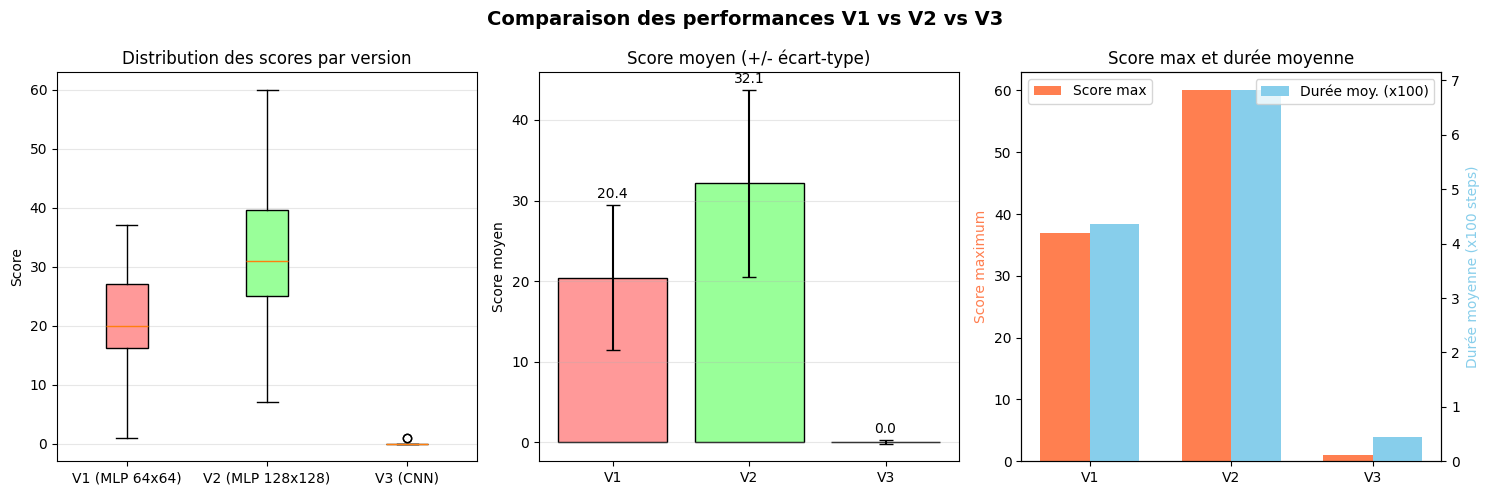

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

data_scores = [scores_v1_full, scores_v2_full, scores_v3_full]
bp = axes[0].boxplot(data_scores, labels=['V1 (MLP 64x64)', 'V2 (MLP 128x128)', 'V3 (CNN)'], patch_artist=True)
colors = ['#ff9999', '#99ff99', '#9999ff']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[0].set_ylabel('Score')
axes[0].set_title('Distribution des scores par version')
axes[0].grid(axis='y', alpha=0.3)

versions = ['V1', 'V2', 'V3']
means = [np.mean(scores_v1_full), np.mean(scores_v2_full), np.mean(scores_v3_full)]
stds = [np.std(scores_v1_full), np.std(scores_v2_full), np.std(scores_v3_full)]
bars = axes[1].bar(versions, means, yerr=stds, capsize=5, color=colors, edgecolor='black')
axes[1].set_ylabel('Score moyen')
axes[1].set_title('Score moyen (+/- écart-type)')
axes[1].grid(axis='y', alpha=0.3)

for bar, mean, std in zip(bars, means, stds):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.5,
                f'{mean:.1f}', ha='center', va='bottom', fontsize=10)

x = np.arange(3)
width = 0.35
max_scores = [max(scores_v1_full), max(scores_v2_full), max(scores_v3_full)]
avg_lengths = [np.mean(lengths_v1_full)/100, np.mean(lengths_v2_full)/100, np.mean(lengths_v3_full)/100]

ax3_twin = axes[2].twinx()
bars1 = axes[2].bar(x - width/2, max_scores, width, label='Score max', color='coral')
bars2 = ax3_twin.bar(x + width/2, avg_lengths, width, label='Durée moy. (x100)', color='skyblue')

axes[2].set_ylabel('Score maximum', color='coral')
ax3_twin.set_ylabel('Durée moyenne (x100 steps)', color='skyblue')
axes[2].set_xticks(x)
axes[2].set_xticklabels(versions)
axes[2].set_title('Score max et durée moyenne')
axes[2].legend(loc='upper left')
ax3_twin.legend(loc='upper right')

plt.suptitle('Comparaison des performances V1 vs V2 vs V3', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 8. Conclusion

### 8.1 Bilan des expérimentations

Ce projet a permis d'explorer l'impact de différents choix de conception sur les performances d'un agent RL pour le jeu Snake :

1. **V1 (Baseline)** : Configuration minimale avec observation vectorielle et réseau MLP simple. Permet d'établir une référence de performance.

2. **V2 (MLP amélioré)** : Augmentation de la capacité du réseau et du temps d'entraînement. Amélioration des performances mais limitation fondamentale due à l'observation locale.

3. **V3 (CNN)** : Passage à une représentation spatiale complète. Le réseau convolutif peut détecter les patterns spatiaux (impasses, forme du corps) et anticiper les situations dangereuses.

### 8.2 Observations clés

- **La représentation compte plus que la capacité du réseau** : Même un MLP plus large (V2) ne peut pas surmonter les limitations d'une observation "myope".

- **Les CNN sont adaptés aux problèmes spatiaux** : La capacité à détecter des patterns dans une image permet une prise de décision plus "intelligente".

- **Le temps d'entraînement augmente avec la complexité** : Les CNN nécessitent significativement plus de timesteps pour converger.

### 8.3 Pistes d'amélioration futures

L'entraînement de réseaux de neurones profonds pour le reinforcement learning nécessite une puissance de calcul considérable. Ne disposant pas de GPU local, nous avons utilisé Google Colab, dont la version gratuite impose plusieurs contraintes majeures. Les sessions Colab sont limitées, avec des déconnexions fréquentes dues à l'instabilité de la connexion ou aux interruptions serveur. Nous avons due utiliser plusieurs comptes Google pour contourner les quotas d'utilisation De plus, nous avons dû adapter notre méthodologie d'entraînement. La mise en place de sauvegardes automatiques (checkpoints) tous les 100 000 timesteps est devenue indispensable pour préserver notre progression. Cette approche, bien que nécessaire, a introduit une complexité supplémentaire dans la gestion des modèles et a généré une fragmentation de notre processus d'apprentissage.

### 8.4 Pistes d'amélioration futures

- **Reward shaping** : Ajouter des récompenses intermédiaires (se rapprocher de la pomme, maintenir de l'espace libre)
- **Frame stacking** : Empiler plusieurs frames pour donner une notion de mouvement/direction
- **Curriculum learning** : Commencer sur une petite grille puis augmenter progressivement
- **Autres algorithmes** : Tester DQN, A2C, ou SAC pour comparer
- **Self-play** : Entraîner plusieurs agents en compétition